---

# **1. Imports, Loading the Datasets, Initializing**

In [2]:
import pandas as pd
import re
import nltk
import emoji
import html
import contractions
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay
from collections import Counter
from wordcloud import WordCloud
from IPython.display import display

nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words("english"))

# Load the datasets
train_data = pd.read_csv("train_dataset.csv")
validation_data = pd.read_csv("val_dataset.csv")
test_data = pd.read_csv("test_dataset.csv")

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Initialize the Logistic Regression model with a random state
logistic_model = LogisticRegression(max_iter=1000, random_state=42)


[nltk_data] Downloading package punkt to /home/christina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/christina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


---

# **2. Exploratory Data Analysis (EDA)** before data processing

**Sentiment Distribution in Training Data**

This bar plot shows the distribution of tweet sentiments in the training dataset and lets us see how balanced the data is in terms of positive (1) and negative (0) tweets.


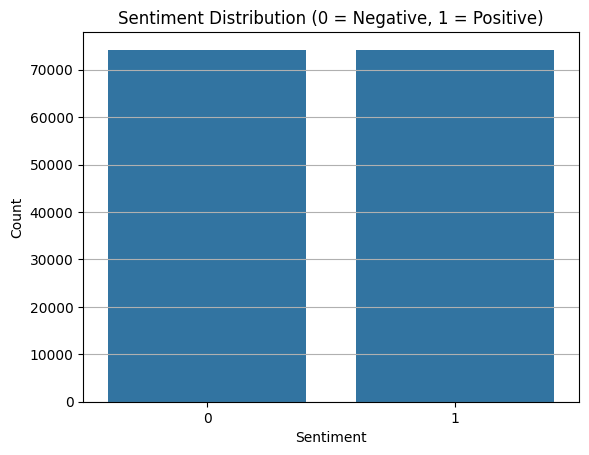

In [3]:
# Show how many tweets are positive vs negative
sns.countplot(x='Label', data=train_data)
plt.title("Sentiment Distribution (0 = Negative, 1 = Positive)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()

**Distribution of Tweet Lengths**

This histogram shows how long tweets are.

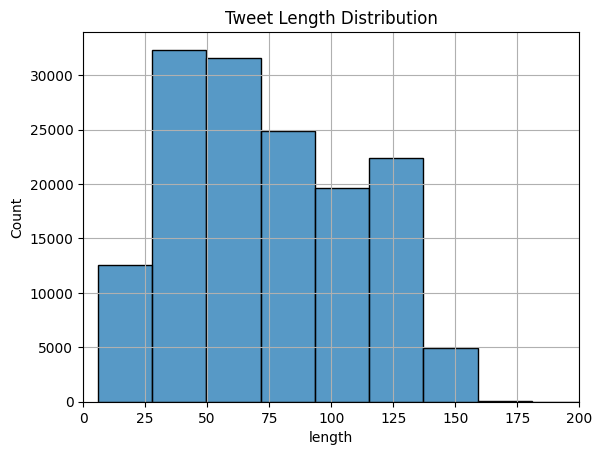

In [4]:
# Show the differenct tweet lengths
train_data['length'] = train_data['Text'].str.len()
sns.histplot(train_data['length'], bins=30)
plt.title("Tweet Length Distribution")
plt.xlim(0, 200)
plt.grid(axis='y')
plt.grid(axis='x')

**Tweet Length by Sentiment**

These plots compare the lengths of the positive and negative tweets. 

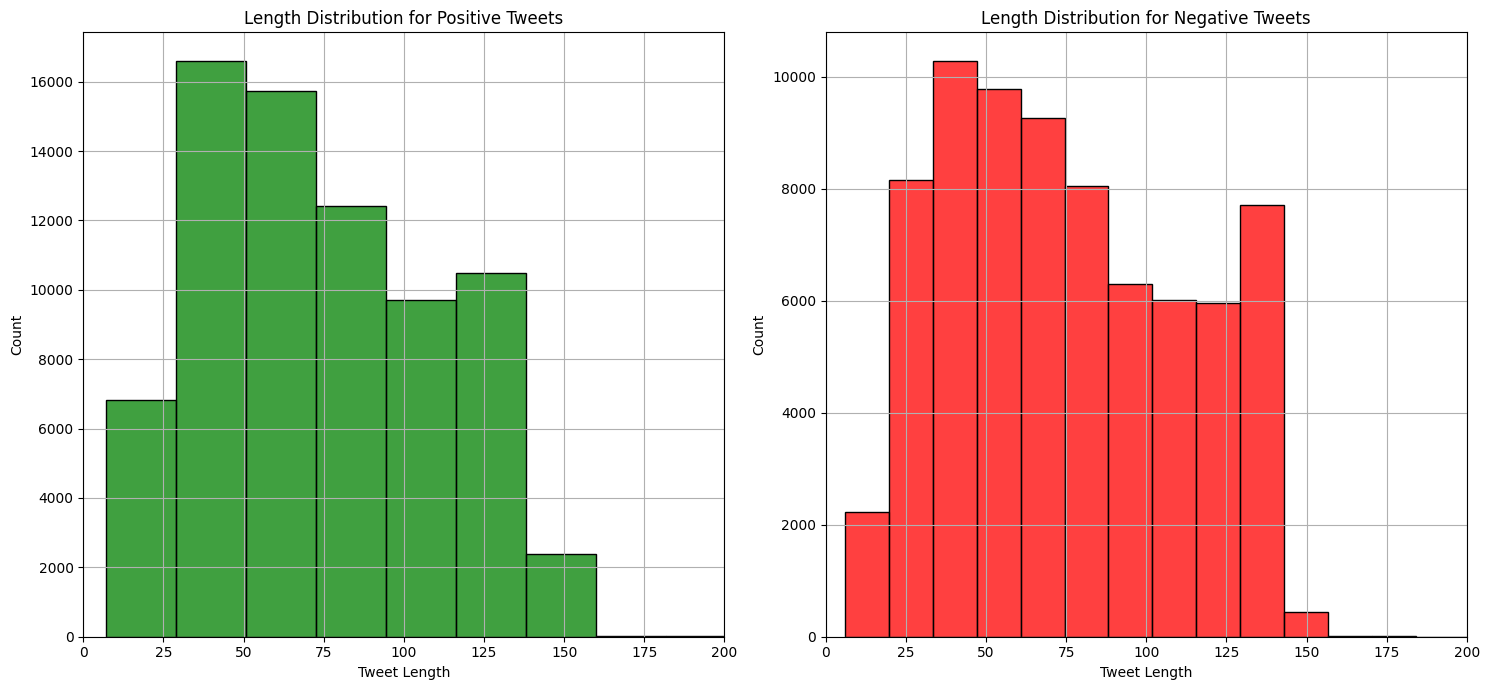

In [5]:
# Separate the lengths of the positive and negative tweets
positive_lengths = train_data[train_data['Label'] == 1]['length']
negative_lengths = train_data[train_data['Label'] == 0]['length']

# Plot the 2 histograms
plt.figure(figsize=(15, 7))

# The histogram for the positive tweets
plt.subplot(1, 2, 1)
sns.histplot(positive_lengths, bins=30, color='green')
plt.title("Length Distribution for Positive Tweets")
plt.xlabel("Tweet Length")
plt.ylabel("Count")
plt.xlim(0, 200)
plt.grid(axis='y')
plt.grid(axis='x')

# The histogram for the negative tweets
plt.subplot(1, 2, 2)
sns.histplot(negative_lengths, bins=30, color='red')
plt.title("Length Distribution for Negative Tweets")
plt.xlabel("Tweet Length")
plt.ylabel("Count")
plt.xlim(0, 200)
plt.grid(axis='y')
plt.grid(axis='x')

plt.tight_layout()
plt.show()

**Top 10 Most Frequent Words by Sentiment**

Compare the most commonly used words in positive and negative tweets. This can show what kind of words are associated with each sentiment.


/tmp/ipykernel_28261/512023300.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(positive_counts), y=list(positive_words), palette="Greens_d")
/tmp/ipykernel_28261/512023300.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(negative_counts), y=list(negative_words), palette="Reds_d")


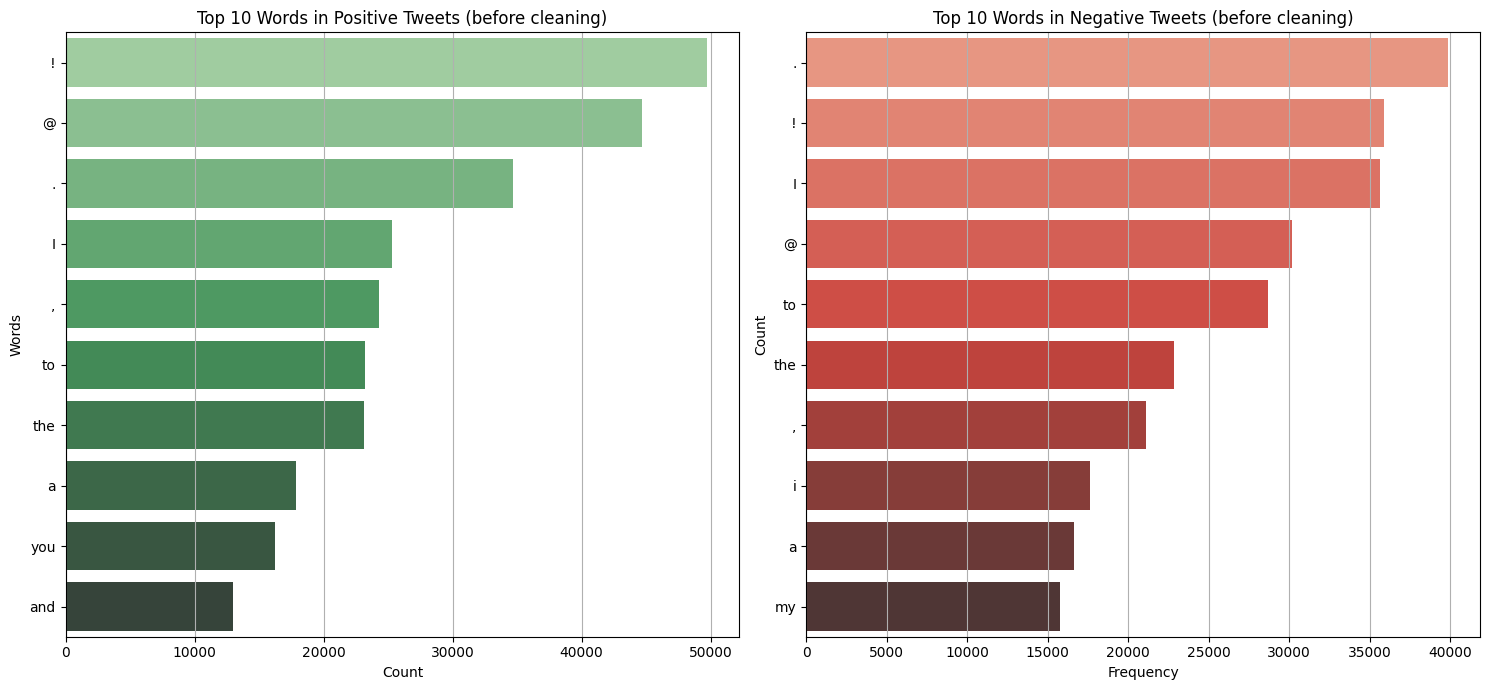

In [6]:

# Seperate the positive and negative tweets
positive_tweets = ' '.join(train_data[train_data['Label'] == 1]['Text'].dropna().values)
negative_tweets = ' '.join(train_data[train_data['Label'] == 0]['Text'].dropna().values)

# Count word frequencies
positive_word_counts = Counter(word_tokenize(positive_tweets))
negative_word_counts = Counter(word_tokenize(negative_tweets))

# Get the top 10 words for each sentiment
top_positive_words = positive_word_counts.most_common(10)
top_negative_words = negative_word_counts.most_common(10)

# Extract the words and counts
positive_words, positive_counts = zip(*top_positive_words)
negative_words, negative_counts = zip(*top_negative_words)

# Plot the results
plt.figure(figsize=(15, 7))

# Plot the top 10 words for positive tweets
plt.subplot(1, 2, 1)
sns.barplot(x=list(positive_counts), y=list(positive_words), palette="Greens_d")
plt.title("Top 10 Words in Positive Tweets (before cleaning)")
plt.xlabel("Count")
plt.ylabel("Words")
plt.grid(axis='x')

# Plot the top 10 words for negative tweets
plt.subplot(1, 2, 2)
sns.barplot(x=list(negative_counts), y=list(negative_words), palette="Reds_d")
plt.title("Top 10 Words in Negative Tweets (before cleaning)")
plt.xlabel("Frequency")
plt.ylabel("Count")
plt.grid(axis='x')

plt.tight_layout()
plt.show()

**Word Cloud of All Tweets**

The word cloud shows the most frequent words across the entire dataset.

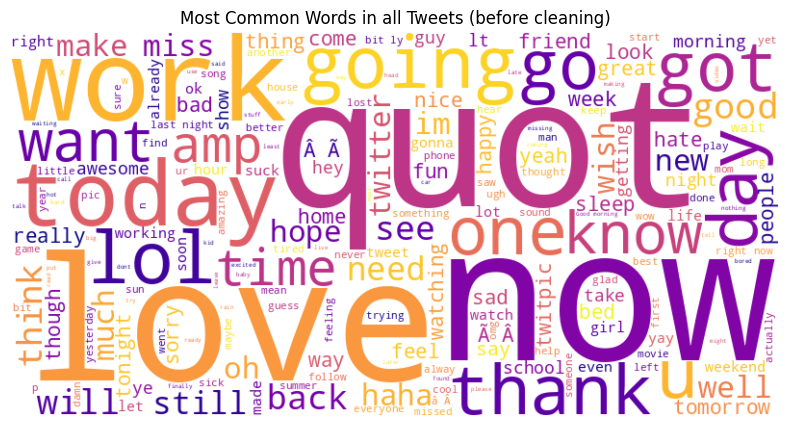

In [7]:
# Get the most common words in all tweets
all_words = ' '.join(train_data['Text'].dropna().values)

# Use them to create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Show the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in all Tweets (before cleaning)")
plt.imshow(wordcloud.recolor(colormap='plasma'), interpolation='bilinear')
plt.show()


**Word Clouds by Sentiment**

These two word clouds show the most frequent words in positive and negative tweets respectively.


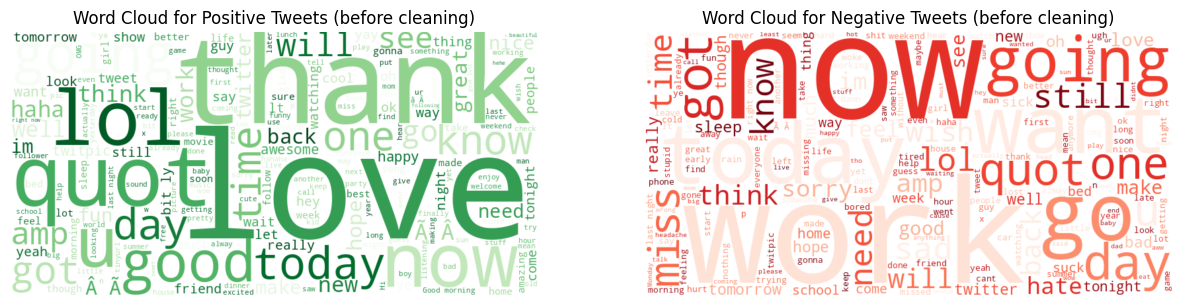

In [8]:
# Generate a word cloud for each
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_tweets)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_tweets)

# Show the word clouds
plt.figure(figsize=(15, 7))

# Plot the positive tweets word cloud
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud.recolor(colormap='Greens'), interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Positive Tweets (before cleaning)")

# Plot the negative tweets word cloud
plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud.recolor(colormap='Reds'), interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Negative Tweets (before cleaning)")

plt.show()


**Hashtag Wordcloud of all Tweets**

This word cloud showcases the most common hashtags in the dataset.


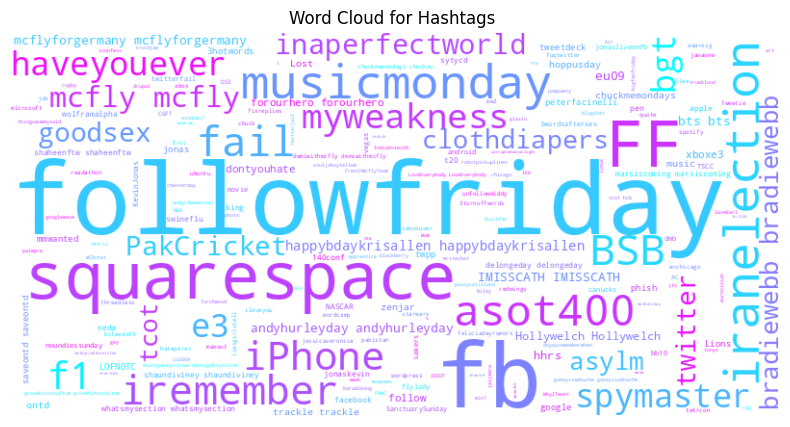

In [9]:
# Extract hashtags from the tweets
hashtags = train_data['Text'].str.findall(r"#(\w+)").explode()

# Combine all hashtags into a single string
hashtags_text = ' '.join(hashtags.dropna())

# Create the word cloud
hashtag_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(hashtags_text)

# Show the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(hashtag_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Hashtags ")
plt.imshow(hashtag_wordcloud.recolor(colormap='cool_r'), interpolation='bilinear')
plt.show()

**Hashtags Workcloud by Sentiment**

These word clouds show the hashtags that are most commonly used in positive and negative tweets. 

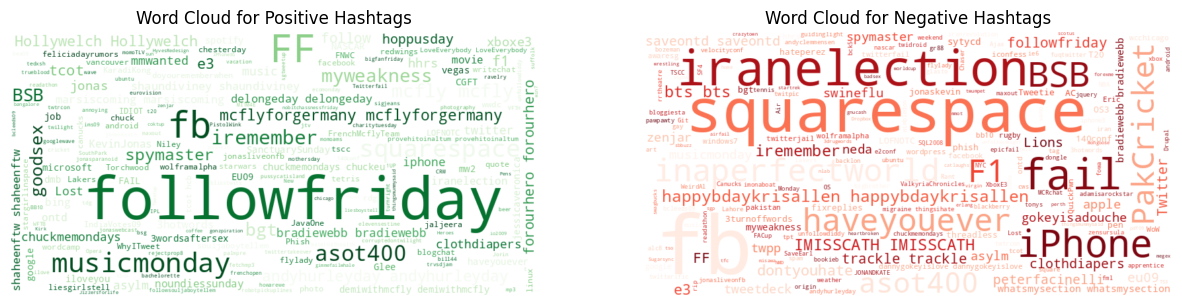

In [10]:
# Extract positive and negative hashtags
positive_hashtags = train_data[train_data['Label'] == 1]['Text'].str.findall(r"#(\w+)").explode()
negative_hashtags = train_data[train_data['Label'] == 0]['Text'].str.findall(r"#(\w+)").explode()

# Combine all positive and negative hashtags into separate strings
positive_hashtags_text = ' '.join(positive_hashtags.dropna())
negative_hashtags_text = ' '.join(negative_hashtags.dropna())

# Create the word clouds
positive_hashtag_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_hashtags_text)
negative_hashtag_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_hashtags_text)

# Show the word clouds
plt.figure(figsize=(15, 7))

# The positive hashtags word cloud
plt.subplot(1, 2, 1)
plt.imshow(positive_hashtag_wordcloud.recolor(colormap='Greens'), interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Positive Hashtags")

# The negative hashtags word cloud
plt.subplot(1, 2, 2)
plt.imshow(negative_hashtag_wordcloud.recolor(colormap='Reds'), interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Negative Hashtags")

plt.show()


---

# **3. Text Preprocessing / Data cleaning**


The `preprocess_text` function cleans and preprocess the tweets. 

In [1]:

def clean_text(text):

    # 1: Make the text lowercase
    text = text.lower()
        
    # 2: Expand contractions 
    text = contractions.fix(text)

    # 3: Convert emojis to words
    text = emoji.demojize(text, delimiters=(" ", " "))

    # 4: Remove HTML entities 
    text = html.unescape(text)

    # 5: Remove mentions and URLs
    text = re.sub(r"@\w+|https?://\S+|#\w+", "", text)
    
    # 5: Remove hashtags but keep the word
    text = re.sub(r"#(\w+)", r"\1", text)

    # 6: Remove punctuation
    text = re.sub(r"[^\w\s]", "", text)

    # 7: Tokenize
    tokens = word_tokenize(text)

    # 8: Lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # 9: Remove stop words
    tokens = [token for token in tokens if token not in stop_words]

    return tokens

First use the function with all the cleaning parameters on.

---

# **4. Exploratory Data Analysis (EDA)** after data processing

**Top 10 Most Frequent Words by Sentiment**

We compare the most commonly used words in positive and negative tweets. These analysis can show what kinds of words are associated with each sentiment.


/tmp/ipykernel_28261/997231783.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(positive_counts), y=list(positive_words), palette="Greens_d")
/tmp/ipykernel_28261/997231783.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(negative_counts), y=list(negative_words), palette="Reds_d")


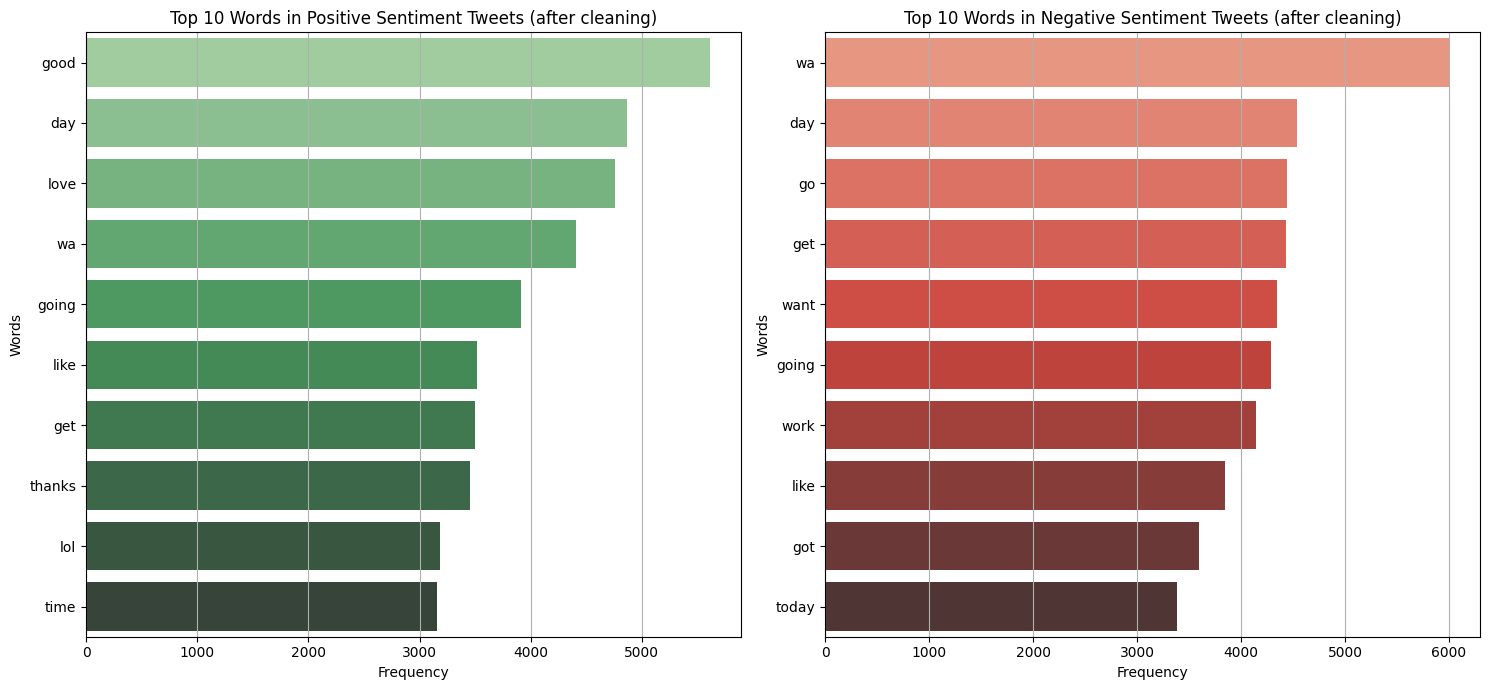

In [13]:
# Separate the positive and negative tweets
positive_tweets = ' '.join(train_data[train_data['Label'] == 1]['cleaned_text'].dropna().values)
negative_tweets = ' '.join(train_data[train_data['Label'] == 0]['cleaned_text'].dropna().values)

# Count word frequencies
positive_word_counts = Counter(word_tokenize(positive_tweets))
negative_word_counts = Counter(word_tokenize(negative_tweets))

# Get the top 10 words for each sentiment
top_positive_words = positive_word_counts.most_common(10)
top_negative_words = negative_word_counts.most_common(10)

# Extract words and counts
positive_words, positive_counts = zip(*top_positive_words)
negative_words, negative_counts = zip(*top_negative_words)

# Plot the results
plt.figure(figsize=(15, 7))

# Positive words
plt.subplot(1, 2, 1)
sns.barplot(x=list(positive_counts), y=list(positive_words), palette="Greens_d")
plt.title("Top 10 Words in Positive Sentiment Tweets (after cleaning)")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.grid(axis='x')

# Negative words
plt.subplot(1, 2, 2)
sns.barplot(x=list(negative_counts), y=list(negative_words), palette="Reds_d")
plt.title("Top 10 Words in Negative Sentiment Tweets (after cleaning)")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.grid(axis='x')

plt.tight_layout()
plt.show()

**Word Cloud of All Tweets**

The word cloud shows the most frequent words across the entire dataset.

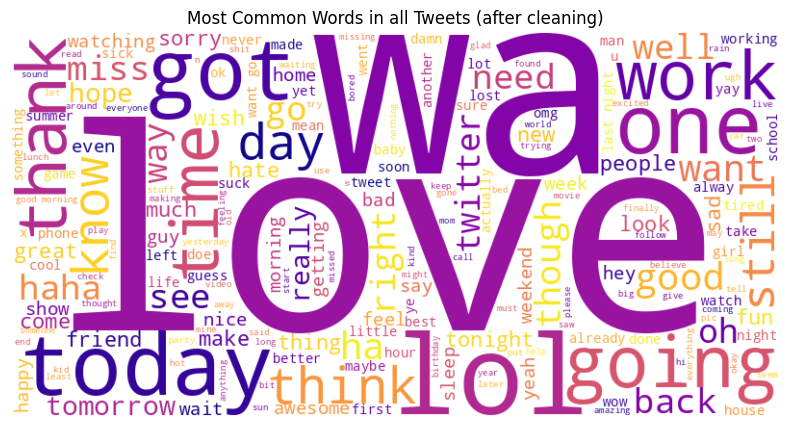

In [14]:
all_words = ' '.join(train_data['cleaned_text'].dropna().values)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in all Tweets (after cleaning)")
plt.imshow(wordcloud.recolor(colormap='plasma'), interpolation='bilinear')
plt.show()


**Word Clouds by Sentiment**

These two word clouds show the most frequent words in positive and negative tweets respectively.

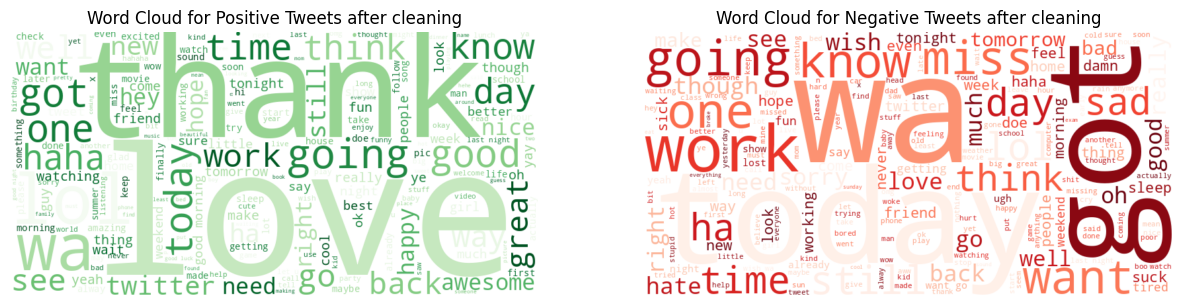

In [15]:
# Generate 2 word clouds
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_tweets)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_tweets)

# Show the word clouds
plt.figure(figsize=(15, 7))

# Positive tweets word cloud
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud.recolor(colormap='Greens'), interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Positive Tweets after cleaning")

# Negative tweets word cloud
plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud.recolor(colormap='Reds'), interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Negative Tweets after cleaning")

plt.show()


---

# **5. Feature Extraction**

In [16]:
# Fit the vectorizer on the training data and transform the datasets
train_tfidf = tfidf_vectorizer.fit_transform(train_data['cleaned_text'])
validation_tfidf = tfidf_vectorizer.transform(validation_data['cleaned_text'])
test_tfidf = tfidf_vectorizer.transform(test_data['cleaned_text'])

# Extract target labels
train_labels = train_data['Label'].values
validation_labels = validation_data['Label'].values

---

# **6. Model Development and Evaluation**

In [17]:

# Fit the model on training data
logistic_model.fit(train_tfidf, train_labels)

# Predict on the validation data
val_predictions = logistic_model.predict(validation_tfidf)

# Evaluate the metrics
accuracy = accuracy_score(validation_labels, val_predictions)
precision = precision_score(validation_labels, val_predictions)
recall = recall_score(validation_labels, val_predictions)
f1 = f1_score(validation_labels, val_predictions)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Accuracy: 0.7601
Precision: 0.7522
Recall: 0.7759
F1-Score: 0.7639


**Learning curve**

The learning curve of this original Logistic Regression model indicates some overfitting: while training accuracy is high, validation accuracy is significanlty lower. However, the validation score gradually improves as we add more data, suggesting that the model gets better with additional training data and generalizes better as the training size increases. 

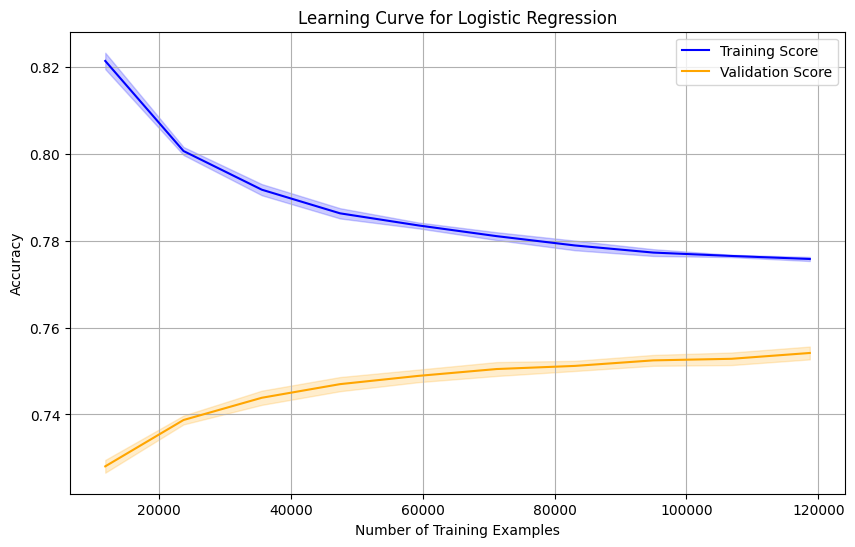

In [18]:
X = train_tfidf
y = train_labels

# Define the model
model = LogisticRegression(max_iter=1000)

# Find learning curve
train_sizes, train_scores, val_scores = learning_curve(
    model,
    X,
    y,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# Calculate mean and std for each training size
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.plot(train_sizes, val_mean, label="Validation Score", color="orange")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color="orange")

plt.title("Learning Curve for Logistic Regression")
plt.xlabel("Number of Training Examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()


---

# **7. Experiments**

In this section we test the effect of different cleaning steps in the accuracy, precision, recall and F1-Score. To experiment, we apply only one preprocessing step per trial (all others are turned off). Then we evaluate the model’s performance for that isolated step.

In [19]:
# Initialize a list to store the results
results = []

# Define preprocessing configurations to test
preprocessing_configs = [
    {"name": "Only Expanding Contractions", "params": (False, True, False, False, False, False, False, False, False)},
    {"name": "Only Converting Emojis", "params": (False, False, True, False, False, False, False, False, False)},
    {"name": "Only Removing HTML Entities", "params": (False, False, False, True, False, False, False, False, False)},
    {"name": "Only Removing Mentions and URLs", "params": (False, False, False, False, True, False, False, False, False)},
    {"name": "Only Removing Hashtags", "params": (False, False, False, False, False, True, False, False, False)},
    {"name": "Only Removing Punctuation", "params": (False, False, False, False, False, False, True, False, False)},
    {"name": "Only Removing Stopwords", "params": (False, False, False, False, False, False, False, True, False)},
    {"name": "Only Lemmatizing", "params": (False, False, False, False, False, False, False, False, True)},
]

# For every configuration, apply the preprocessing and train the model
for config in preprocessing_configs:
    
    # Apply the function
    train_data['cleaned_text'] = train_data['Text'].apply(lambda x: preprocess_text(x, *config["params"]))
    validation_data['cleaned_text'] = validation_data['Text'].apply(lambda x: preprocess_text(x, *config["params"]))
    
    # Transform the text data using TF-IDF
    train_tfidf = tfidf_vectorizer.fit_transform(train_data['cleaned_text'])
    validation_tfidf = tfidf_vectorizer.transform(validation_data['cleaned_text'])
    
    # Train the model
    logistic_model.fit(train_tfidf, train_labels)
    
    # Predict on the validation data
    val_predictions = logistic_model.predict(validation_tfidf)
    
    # Calculate the metrics
    accuracy = accuracy_score(validation_labels, val_predictions)
    precision = precision_score(validation_labels, val_predictions)
    recall = recall_score(validation_labels, val_predictions)
    f1 = f1_score(validation_labels, val_predictions)
    
    # Store the results
    results.append({
        "Experiment": config["name"],
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })


In [20]:
# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results as a table, sorted by accuracy
results_df.sort_values(by="Accuracy", ascending=False, inplace=True)
display(results_df)

,Experiment,Accuracy,Precision,Recall,F1-Score
5,Only Removing Punctuation,0.787032,0.782000,0.795981,0.788929
3,Only Removing Mentions and URLs,0.786796,0.781013,0.797113,0.788981
0,Only Expanding Contractions,0.786324,0.781149,0.795556,0.788287
4,Only Removing Hashtags,0.786206,0.780578,0.796264,0.788343
1,Only Converting Emojis,0.786041,0.780559,0.795839,0.788125
2,Only Removing HTML Entities,0.785499,0.779807,0.795698,0.787672
6,Only Removing Stopwords,0.784885,0.779387,0.794754,0.786996
7,Only Lemmatizing,0.772620,0.765297,0.786452,0.775731


In the next step of experimenting, we combine different cleaning steps to get the best possible results.

In [21]:
# Configurations to test combinations of preprocessing steps
more_configs = [
    {"name": "All Steps", "params": (True, True, True, True, True, True, True, True, True)},
    {"name": "Top 3 Only", "params": (True, False, False, False, False, True, False, False, False)},
    {"name": "All Except Lemmatization", "params": (True, True, True, True, True, True, True, True, False)},
    {"name": "All Except Stopwords", "params": (True, True, True, True, True, True, True, False, True)},
    {"name": "All Except Mentions/URLs", "params": (True, True, True, True, False, True, True, True, True)},
    {"name": "Noise-Reduction Only", "params": (False, False, False, True, True, False, True, False, False)},
    {"name": "Meaning-Preserving Only", "params": (True, True, False, False, False, False, False, False, True)},
    {"name": "Worst 3 Only", "params": (False, True, False, False, False, False, False, True, True)},
]

# For every configuration, apply the preprocessing and train the model
for config in more_configs:
    
    # Apply the function
    train_data['cleaned_text'] = train_data['Text'].apply(lambda x: preprocess_text(x, *config["params"]))
    validation_data['cleaned_text'] = validation_data['Text'].apply(lambda x: preprocess_text(x, *config["params"]))
    
    # Transform the data using TF-IDF
    train_tfidf = tfidf_vectorizer.fit_transform(train_data['cleaned_text'])
    validation_tfidf = tfidf_vectorizer.transform(validation_data['cleaned_text'])
    
    # Train the model
    logistic_model.fit(train_tfidf, train_labels)
    
    # Predict on the validation data
    val_predictions = logistic_model.predict(validation_tfidf)
    
    # Calculate the metrics
    accuracy = accuracy_score(validation_labels, val_predictions)
    precision = precision_score(validation_labels, val_predictions)
    recall = recall_score(validation_labels, val_predictions)
    f1 = f1_score(validation_labels, val_predictions)
    
    # Store the results
    results.append({
        "Experiment": config["name"],
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })


In [22]:
# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results as a table, sorted by accuracy
results_df.sort_values(by="Accuracy", ascending=False, inplace=True)
display(results_df)

,Experiment,Accuracy,Precision,Recall,F1-Score
5,Only Removing Punctuation,0.787032,0.782000,0.795981,0.788929
3,Only Removing Mentions and URLs,0.786796,0.781013,0.797113,0.788981
0,Only Expanding Contractions,0.786324,0.781149,0.795556,0.788287
4,Only Removing Hashtags,0.786206,0.780578,0.796264,0.788343
9,Top 3 Only,0.786206,0.780552,0.796311,0.788353
1,Only Converting Emojis,0.786041,0.780559,0.795839,0.788125
13,Noise-Reduction Only,0.785617,0.780376,0.794990,0.787615
2,Only Removing HTML Entities,0.785499,0.779807,0.795698,0.787672
6,Only Removing Stopwords,0.784885,0.779387,0.794754,0.786996
10,All Except Lemmatization,0.783706,0.778772,0.792585,0.785617


---

# **8. Final Evaluation Results**

Based on the previous result the best configuration for the cleaning function is **"Only Removing Punctuation"**. 

In [23]:
# Apply the "Only Removing Punctuation" cleaning setup
train_data['cleaned_text'] = train_data['Text'].apply(lambda x: preprocess_text(
    x,
    lowercase=False,
    expand_contractions=False,
    convert_emojis=False,
    remove_html_entities=False,
    remove_mentions_and_urls=False,
    remove_hashtags=False,
    remove_punctuation=True,
    lemmatize=False,
    remove_stopwords=False
))

validation_data['cleaned_text'] = validation_data['Text'].apply(lambda x: preprocess_text(
    x,
    lowercase=False,
    expand_contractions=False,
    convert_emojis=False,
    remove_html_entities=False,
    remove_mentions_and_urls=False,
    remove_hashtags=False,
    remove_punctuation=True,
    lemmatize=False,
    remove_stopwords=False
))

test_data['cleaned_text'] = test_data['Text'].apply(lambda x: preprocess_text(
    x,
    lowercase=False,
    expand_contractions=False,
    convert_emojis=False,
    remove_html_entities=False,
    remove_mentions_and_urls=False,
    remove_hashtags=False,
    remove_punctuation=True,
    lemmatize=False,
    remove_stopwords=False
))

# Transform the text data using TF-IDF
train_tfidf = tfidf_vectorizer.fit_transform(train_data['cleaned_text'])
validation_tfidf = tfidf_vectorizer.transform(validation_data['cleaned_text'])
test_tfidf = tfidf_vectorizer.transform(test_data['cleaned_text'])

# Train the model
logistic_model.fit(train_tfidf, train_labels)

# Predict on the validation data
val_predictions = logistic_model.predict(validation_tfidf)

# Predict on the test data
test_predictions = logistic_model.predict(test_tfidf)

# Evaluate the metrics on validation data
accuracy = accuracy_score(validation_labels, val_predictions)
precision = precision_score(validation_labels, val_predictions)
recall = recall_score(validation_labels, val_predictions)
f1 = f1_score(validation_labels, val_predictions)

# Print results
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1-Score: {f1:.4f}")

Validation Accuracy: 0.7870
Validation Precision: 0.7820
Validation Recall: 0.7960
Validation F1-Score: 0.7889


**Learning Curve (Final Preprocessing Setup)**

This learning curve shows how the model's performance improves as we increase the number of training samples, after applying the final selected preprocessing setup. The validation accuracy improves steadily, showing that the model gets better with more data. 

Compared to the original learning curve, which had a slightly better training score and validation curve, this version shows a more balanced behavior. The previous curve had a sharper gap between training and validation accuracy, which means heavier overfitting. In contrary, this final configuration trades a bit of training performance for better generalization.

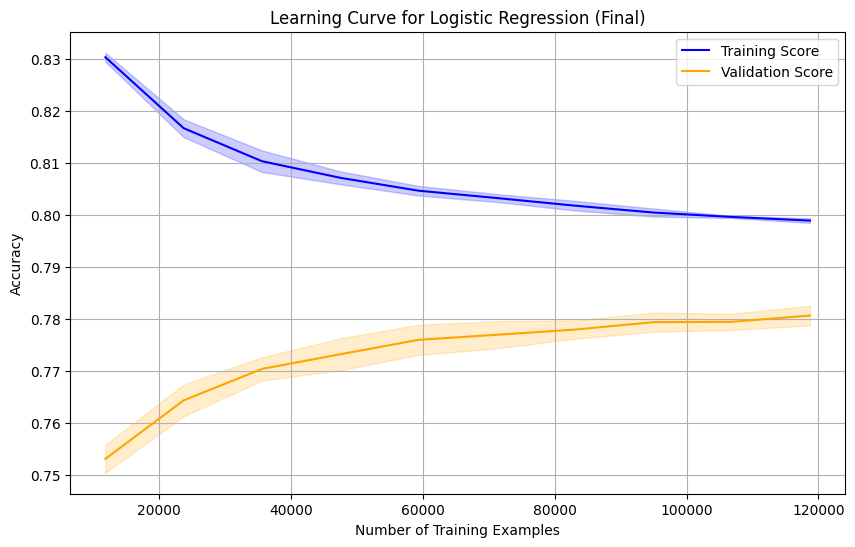

In [24]:
X = train_tfidf
y = train_labels

# Define the model
model = LogisticRegression(max_iter=1000)

# Find learning curve
train_sizes, train_scores, val_scores = learning_curve(
    model,
    X,
    y,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# Calculate mean and std for each training size
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.plot(train_sizes, val_mean, label="Validation Score", color="orange")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color="orange")

plt.title("Learning Curve for Logistic Regression (Final)")
plt.xlabel("Number of Training Examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()


**Confusion Matrix**

A confusion matrix for the predictions made on the test dataset. This provides insights into the model's performance by showing the counts of true positives, true negatives, false positives, and false negatives.

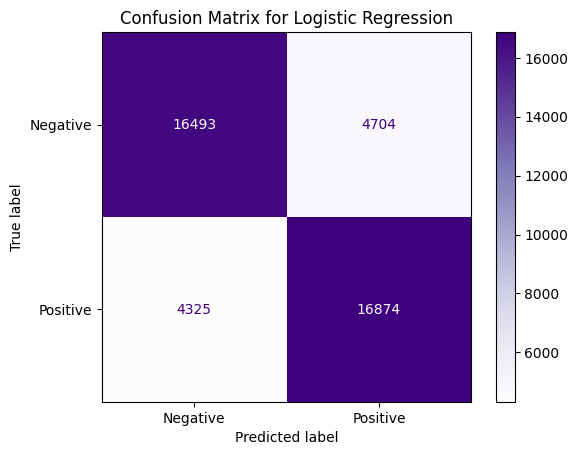

In [25]:
# Generate the confusion matrix
cm = confusion_matrix(validation_labels, val_predictions)

# Show the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Purples)
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

**Classification Report**

This report summarizes how well the model performs on each class in the validation set. It shows metrics like precision, recall, and F1-score for both the "Negative" and "Positive" labels.

- **Precision** shows how many of the predicted positives were actually positive.
- **Recall** shows how many actual positives were correctly predicted.
- **F1-score** mixes precision and recall into a single score.
- **Support** indicates how many samples belong to each class.

Overall, the model performs consistently across both classes, with a balanced accuracy of 79%, which showcases good generalization.

In [26]:
# Generate the classification report
report = classification_report(validation_labels, val_predictions, target_names=['Negative', 'Positive'])

# Print the report
print(report)

              precision    recall  f1-score   support

    Negative       0.79      0.78      0.79     21197
    Positive       0.78      0.80      0.79     21199

    accuracy                           0.79     42396
   macro avg       0.79      0.79      0.79     42396
weighted avg       0.79      0.79      0.79     42396



**ROC Curve and AUC**

This plot shows the ROC (Receiver Operating Characteristic) curve for the model on the validation set. It helps show how well the model separates positive from negative tweets at different classification thresholds. The curve plots the true positive rate against the false positive rate. 

We also calculate the AUC (Area Under the Curve), which turns the overall performance of the model into a number. Since the AUC score is close to 1 (AUC = 0.8661), the model is doing a good job at distinguishing between the two classes.

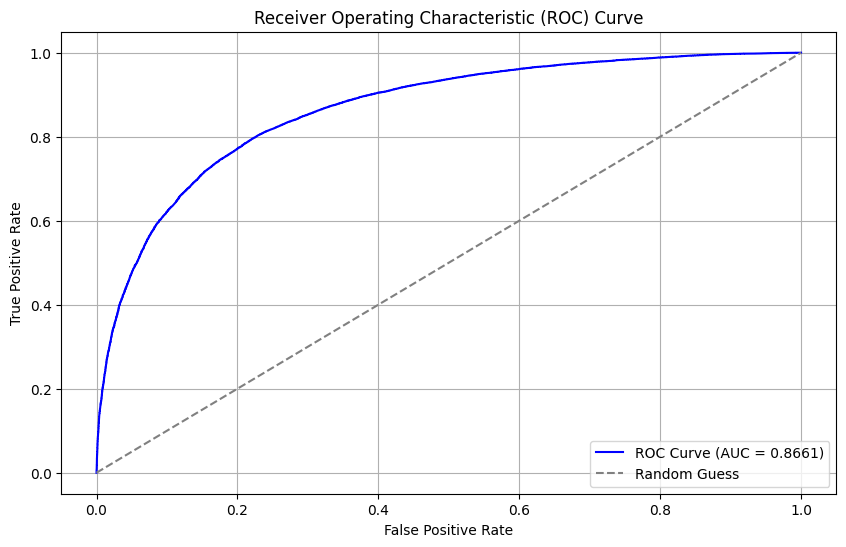

In [27]:
# Predict probabilities for the validation data
val_probabilities = logistic_model.predict_proba(validation_tfidf)[:, 1]

# Find the ROC curve
fpr, tpr, thresholds = roc_curve(validation_labels, val_probabilities)

# Find the AUC 
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

---

# **9. Create the submission DataFrame**

In [29]:
submission = pd.DataFrame({
    'ID': test_data['ID'], 
    'Label': test_predictions
})

submission.to_csv("submission.csv", index=False)
